C:\Users\AlbinXavier\AppData\Local\Temp\ipykernel_28644\282977250.py:13: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  ivs = pd.read_csv("../datasets/visitor_survey.csv", parse_dates=["date"])



[Forest (lags + quarter + trend)] Hold-out accuracy
   RMSE   : 490.030
   MAE    : 490.030
   MAPE%  : 9.942
   sMAPE% : 10.462

Forecast results saved to: ../output/Model_03_Forest_IVS_AvgSpend.csv


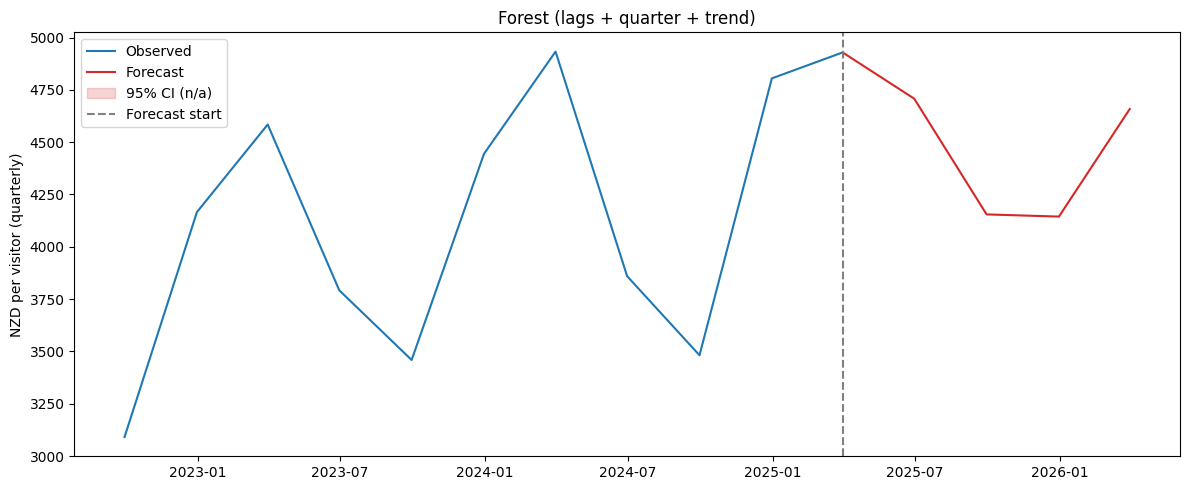

In [1]:
# model_03_forest_ivs.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from pandas.tseries.frequencies import to_offset

# ============== Data ==============
ivs = pd.read_csv("../datasets/visitor_survey.csv", parse_dates=["date"])
ivs["treated_spend"]  = pd.to_numeric(ivs["treated_spend"], errors="coerce")
ivs["vem_pop_weight"] = pd.to_numeric(ivs["vem_pop_weight"], errors="coerce")

ivs_q = (
    ivs.groupby("date")[["treated_spend", "vem_pop_weight"]]
    .apply(lambda g: np.average(g["treated_spend"], weights=g["vem_pop_weight"]))
    .reset_index(name="avg_spend")
).set_index("date").sort_index()

y = ivs_q["avg_spend"].astype(float)


# ============== Metrics ==============
def _metrics(y_true: pd.Series, y_pred: pd.Series):
    y_true, y_pred = y_true.align(y_pred, join="inner")
    a, f = y_true.values.astype(float), y_pred.values.astype(float)

    rmse = np.sqrt(np.mean((f - a) ** 2))
    mae  = np.mean(np.abs(f - a))
    mape = np.mean(np.abs((f[a!=0] - a[a!=0]) / a[a!=0])) * 100 if (a!=0).any() else np.nan
    smape = (2*np.mean(np.abs(f-a)/(np.abs(a)+np.abs(f))))*100 if (np.abs(a)+np.abs(f)).any() else np.nan
    return {"RMSE": rmse, "MAE": mae, "MAPE%": mape, "sMAPE%": smape}

def _print_metrics(title: str, m: dict):
    print(f"\n[{title}] Hold-out accuracy")
    for k,v in m.items():
        print(f"   {k:7}: {v:,.3f}" if np.isfinite(v) else f"   {k:7}: nan")


# ============== Forest helpers ==============
RF_PARAMS = dict(
    n_estimators=600,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42,
)

def _infer_offset(idx: pd.DatetimeIndex):
    # Try to preserve original frequency; fall back to quarterly.
    if getattr(idx, "freq", None) is not None:
        return idx.freq
    inf = pd.infer_freq(idx)
    return to_offset(inf if inf is not None else "Q")

def _make_design_matrix(y: pd.Series, max_lag: int = 8) -> pd.DataFrame:
    df = pd.DataFrame({"y": y}, index=y.index.copy())
    for L in range(1, max_lag + 1):
        df[f"y_lag{L}"] = y.shift(L)
    df["quarter"] = df.index.quarter.astype("int8")
    df["trend"]   = np.arange(len(df), dtype="int32")
    return df.dropna().copy()

def _fit_forest(X_train: pd.DataFrame, y_train: pd.Series):
    cat_cols = ["quarter"]
    num_cols = [c for c in X_train.columns if c not in cat_cols]
    pre = ColumnTransformer(
        transformers=[
            ("cats", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
            ("nums", "passthrough", num_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )
    model = RandomForestRegressor(**RF_PARAMS)
    pipe = Pipeline(steps=[("prep", pre), ("rf", model)])
    pipe.fit(X_train, y_train)
    return pipe

def _recursive_predict(pipe, last_row: pd.Series, idxs: pd.DatetimeIndex) -> pd.Series:
    preds = []
    curr = last_row.copy()
    # detect max lag from columns like y_lag{K}
    max_lag = max(int(c.split("y_lag")[1]) for c in curr.index if c.startswith("y_lag"))

    for t in idxs:
        curr["quarter"] = t.quarter
        curr["trend"] = int(curr["trend"]) + 1

        X_one = curr.drop(labels=["y"], errors="ignore").to_frame().T
        y_hat = float(pipe.predict(X_one)[0])
        preds.append((t, y_hat))

        # shift lags
        for L in range(max_lag, 1, -1):
            curr[f"y_lag{L}"] = curr[f"y_lag{L-1}"]
        curr["y_lag1"] = y_hat
        curr["y"] = y_hat

    return pd.Series(dict(preds))


# ============== Forest Forecast (mirrors ARIMA version) ==============
def forest_forecast(
    y: pd.Series,
    max_lag: int = 8,
    k_test: int = 4,
    h_future: int = 8,
    title: str = "Forest Forecast (lags + quarter + trend)",
):
    # --- Split
    y_train, y_test = y.iloc[:-k_test], y.iloc[-k_test:]

    # --- Supervised matrix
    df_all   = _make_design_matrix(y, max_lag=max_lag)
    df_train = df_all.loc[df_all.index <= y_train.index[-1]].copy()

    X_train = df_train.drop(columns=["y"])
    y_train_super = df_train["y"]
    pipe = _fit_forest(X_train, y_train_super)

    # --- Seed recursion from the row just before first test date
    first_test_date = y_test.index.min()
    start_row_idx = df_all.index[df_all.index < first_test_date].max()
    last_row = df_all.loc[start_row_idx].copy()

    # --- Build forecast indexes
    off = _infer_offset(y.index)
    future_idx = pd.date_range(y.index[-1] + off, periods=h_future, freq=off)
    idx_all = y_test.index.append(future_idx)

    # --- Recursive predictions
    y_pred_all = _recursive_predict(pipe, last_row, idx_all)
    y_pred_test = y_pred_all.loc[y_test.index]

    # --- Metrics on hold-out
    metrics = _metrics(y_test, y_pred_test)
    _print_metrics(title, metrics)

    # --- Fit on full data and forecast future horizon
    df_full = df_all.copy()
    X_full = df_full.drop(columns=["y"])
    y_full_super = df_full["y"]
    pipe_full = _fit_forest(X_full, y_full_super)

    # Seed from last available row for full data
    last_row_full = df_full.iloc[-1].copy()
    y_pred_future = _recursive_predict(pipe_full, last_row_full, future_idx)

    # --- Extend forecast line to connect with last observed
    forecast_line = pd.concat([y.iloc[[-1]], y_pred_future])

    # --- NaN CI (no parametric CI from RF) with a connecting point at last observed
    ci_future_ext = pd.DataFrame(index=forecast_line.index, columns=["Lower_CI", "Upper_CI"], dtype="float64")
    ci_future_ext.iloc[0, :] = y.iloc[-1]  # connect band at the split point
    # rest remain NaN

    # --- Save forecast results to CSV
    out_csv = "../output/Model_03_Forest_IVS_AvgSpend.csv"
    df_out = pd.DataFrame({
        "Observed": y.reindex(forecast_line.index),
        "Forecast": forecast_line,
        "Lower_CI": ci_future_ext["Lower_CI"],
        "Upper_CI": ci_future_ext["Upper_CI"],
    })
    df_out.index.name = "Date"
    df_out.to_csv(out_csv)
    print(f"\nForecast results saved to: {out_csv}")

    # --- Plot
    plt.figure(figsize=(12,5))
    plt.plot(y.index, y.values, label="Observed", color="tab:blue")
    plt.plot(forecast_line.index, forecast_line.values, label="Forecast", color="tab:red")
    # CI band is mostly NaN (as intended); only a connector at the split point
    plt.fill_between(ci_future_ext.index, ci_future_ext["Lower_CI"], ci_future_ext["Upper_CI"],
                     color="tab:red", alpha=0.2, label="95% CI (n/a)")

    plt.axvline(y.index[-1], color="gray", linestyle="--", label="Forecast start")
    plt.title(title)
    plt.ylabel("NZD per visitor (quarterly)")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ============== Run ==============
forest_forecast(
    y,
    max_lag=8,
    k_test=min(4, max(1, len(y)//6)),
    h_future=4,
    title="Forest (lags + quarter + trend)"
)
